# Inputs

In [1]:
version = 'vr4'
V = {}

In [2]:
V['x'] = '0.999950000417*(x_dut[0] - 13.2) + 0.00999983333417*(y_dut[0] - 21.5) + 13.2'
V['y'] = '0.999950000417*(y_dut[0] - 21.5) - 0.00999983333417*(x_dut[0] - 13.2) + 21.5'

In [3]:
selection = '(amp[14] != 0 && integral[14] != 0) && (amp[14]>903.173370928 && amp[14]<952.78858754) && ntracks==1 && chi2<5 && (amp[9] != 0 && integral[9] != 0) && (-integral[9]>1.60556938972 && -integral[9]<3.76916116035) && ntracks==1 && chi2<5 && (amp[15] != 0 && integral[15] != 0) && (amp[15]>878.724318579 && amp[15]<940.544141591) && ntracks==1 && chi2<5 && (amp[9] != 0 && integral[9] != 0) && (-integral[9]>1.60556938972 && -integral[9]<3.76916116035) && ntracks==1 && chi2<5 && (amp[9] != 0 && integral[9] != 0) && (-integral[9]>1.60556938972 && -integral[9]<3.76916116035) && ntracks==1 && chi2<5 && (amp[24] != 0 && integral[24] != 0) && (amp[24]>142.461008401 && amp[24]<410.806345112) && ntracks==1 && chi2<5 && (amp[9] != 0 && integral[9] != 0) && (-integral[9]>1.60556938972 && -integral[9]<3.76916116035) && ntracks==1 && chi2<5 && (amp[25] != 0 && integral[25] != 0) && (amp[25]>222.62843525 && amp[25]<488.050949478) && ntracks==1 && chi2<5 && (amp[9] != 0 && integral[9] != 0) && (-integral[9]>1.60556938972 && -integral[9]<3.76916116035) && ntracks==1 && chi2<5 && (0.999950000417*(y_dut[0] - 21.5) - 0.00999983333417*(x_dut[0] - 13.2) + 21.5 < 23.0 && 0.999950000417*(y_dut[0] - 21.5) - 0.00999983333417*(x_dut[0] - 13.2) + 21.5 > 20.0) && (0.999950000417*(x_dut[0] - 13.2) + 0.00999983333417*(y_dut[0] - 21.5) + 13.2 < 30.4 && 0.999950000417*(x_dut[0] - 13.2) + 0.00999983333417*(y_dut[0] - 21.5) + 13.2 > -4.0) && (LP1_50[14]!= 0 && LP1_50[15]!=0)&& (0.5*(LP1_50[14]+LP1_50[15]) - gaus_mean[9] < -3.66500835419 && 0.5*(LP1_50[14]+LP1_50[15]) - gaus_mean[9] > -4.40391368866)'
dt_lim = [-4.40391368866, -3.66500835419]

In [4]:
V['dT'] = '0.5*(LP1_50[14]+LP1_50[15]) - gaus_mean[9]'
V['dTL'] = 'LP1_50[14] - gaus_mean[9]'
V['dTR'] = 'LP1_50[15] - gaus_mean[9]'

V['xlike'] = 'LP1_50[14]-LP1_50[15]'

V['ampL'] = 'amp[24]'
V['ampR'] = 'amp[25]'

In [5]:
N_bins = [20,50]
dx = 20
width_x = 20

# Preamble

In [6]:
import numpy as np
import os, re, shutil, time
import argparse
import itertools
from prettytable import PrettyTable
import matplotlib.pyplot as plt

import ROOT as rt
from root_numpy import tree2array, tree2rec
from lib.histo_utilities import create_TH1D, create_TH2D, quantile, create_prof1D, EstimateDispersion
from lib.cebefo_style import cebefo_style, Set_2D_colz_graphics
cebefo_style()
rt.gErrorIgnoreLevel = 6000

Welcome to JupyROOT 6.12/06


In [7]:
file_template = '../data/VME/RECO/'+version+'/DataVMETiming_RunXXX.root'
infile = '../results/'+version+'/TracksConsistency_Good.txt'

In [8]:
runs = np.sort(np.loadtxt(infile).astype(np.int))
runs = list(runs)
input_file = map(lambda x: file_template.replace('XXX', str(x)), runs)

chain = rt.TChain('pulse')
for f in input_file:
    chain.Add(f)

In [9]:
data_raw = tree2array(chain, V.values(), selection).view(np.recarray)
data = np.zeros((data_raw.shape[0], len(data_raw[0])))
data_struct = []

for iev, d in enumerate(data_raw):
    data[iev] = [d[0][0], d[1][0], d[2][0], d[3][0], d[4][0], d[5], d[6], d[7][0]]
    data_struct.append((d[0][0], d[1][0], d[2][0], d[3][0], d[4][0], d[5], d[6], d[7][0]))


dtypes = zip(V.keys(), len(V.keys())*['f8'])
sdata = np.array(data_struct, dtype=dtypes)

In [10]:
sdata['x'] -= np.min(sdata['x'])

### Noise check

In [11]:
bt = 'baseline_RMS[{}]'
for b in [bt.format(i) for i in [9, 14, 15, 24, 25]]:
    arr = tree2array(chain, b, selection).view(np.recarray).flatten()
    print '{} = {:.1f} +/- {:.1f} mV'.format(b, np.mean(arr), np.std(arr))

baseline_RMS[9] = 1.1 +/- 0.3 mV
baseline_RMS[14] = 3.7 +/- 2.9 mV
baseline_RMS[15] = 5.6 +/- 4.9 mV
baseline_RMS[24] = 1.1 +/- 0.2 mV
baseline_RMS[25] = 1.0 +/- 0.2 mV


# Making the plots

In [12]:
def MakeSumLR_prof_plot(S, L, R, x, tag, lim=None, draw_opt='', prof_opt='', units='ns'):
    unique_id = str(int(100*time.time()))
    rt.gStyle.SetHistLineWidth(2)
    h_sum = create_prof1D(x, S, name='h_sum_'+unique_id, 
                          title=tag+' in selected events', 
                          binning=[N_bins[0], -width_x+dx, width_x+dx], 
                          axis_title = ['x [mm]',tag+' ['+units+']'],
                          opt=prof_opt)
    h_sum.SetStats(0)
    if lim != None:
        h_sum.GetYaxis().SetRangeUser(lim[0], lim[1])
    h_sum.GetYaxis().SetTitleOffset(1.5)
    
    h_L = create_prof1D(x, L, name='h_L_'+unique_id,
                          binning=[N_bins[0], -width_x+dx, width_x+dx],
                          opt=prof_opt)
    
    h_R = create_prof1D(x, R, name='h_R_'+unique_id,
                          binning=[N_bins[0], -width_x+dx, width_x+dx],
                          opt=prof_opt)
    
    can = rt.TCanvas('c_'+unique_id, 'c', 400, 500)
    leg = rt.TLegend(0.82,0.78,0.98,0.93)

    h_sum.SetLineColor(1)
    h_sum.Draw(draw_opt)
    leg.AddEntry(h_sum, ' L+R', 'l')
    h_L.SetLineColor(2)
    h_L.Draw('SAME'+draw_opt)
    leg.AddEntry(h_L, ' L', 'l')
    h_R.SetLineColor(4)
    h_R.Draw('SAME'+draw_opt)
    leg.AddEntry(h_R, ' R', 'l')
    leg.Draw()

    rt.gPad.SetLeftMargin(0.16)
    can.obj = [h_sum, h_L, h_R, leg]
    return can

In [13]:
def MakeSumLR_hist_plot(S, L, R, tag, lim=None, draw_opt='', weights=None):
    unique_id = str(int(100*time.time()))
    rt.gStyle.SetHistLineWidth(2)
    h_sum = create_TH1D(S, name='h_sum_'+unique_id,
                          title=tag+' in selected events', 
                          binning=[2*N_bins[0], np.min(S), np.max(S)], 
                          axis_title = [tag+' [ns]', 'Events'],
                          weights=weights
                          )
    h_sum.SetStats(0)
    h_sum.Sumw2()
    if lim != None:
        h_sum.GetYaxis().SetRangeUser(lim[0], lim[1])
    h_sum.GetYaxis().SetTitleOffset(1.5)
    
    h_L = create_TH1D(L, name='h_L_'+unique_id,
                          binning=h_sum.binning,
                          weights=weights
                          )
    h_L.Sumw2()
    
    h_R = create_TH1D(R, name='h_R_'+unique_id,
                          binning=h_sum.binning,
                          weights=weights
                          )
    h_R.Sumw2()
    
    can = rt.TCanvas('c_'+unique_id, 'c', int(800*2/3.), int(600*2/3.))
    leg = rt.TLegend(0.72,0.68,0.98,0.93)

    h_sum.SetLineColor(1)
    h_sum.Draw(draw_opt)
    s, ds = EstimateDispersion(S, w=weights)
    leg.AddEntry(h_sum, ' L+R: {:.1f} +/- {:.1f} ps'.format(1e3*s, 1e3*ds), 'l')
    h_L.SetLineColor(2)
    h_L.Draw('SAME'+draw_opt)
    s, ds = EstimateDispersion(L, w=weights)
    leg.AddEntry(h_L, ' L: {:.1f} +/- {:.1f} ps'.format(1e3*s, 1e3*ds), 'l')
    h_R.SetLineColor(4)
    h_R.Draw('SAME'+draw_opt)
    s, ds = EstimateDispersion(R, w=weights)
    leg.AddEntry(h_R, ' R: {:.1f} +/- {:.1f} ps'.format(1e3*s, 1e3*ds), 'l')
    leg.Draw()

    rt.gPad.SetLeftMargin(0.16)
    can.obj = [h_sum, h_L, h_R, leg]
    return can

In [14]:
def plot_it(S,L,R, lims = [None, None, None], weights=None):
    if lims[0] == None:
        lims[0] = dt_lim
    c = MakeSumLR_prof_plot(S, L, R, sdata['x'], 'Average time stamp', lim=lims[0])
    
    if lims[1] == None:
        lims[1] = [0,120]
    c2 = MakeSumLR_prof_plot(1e3*S, 1e3*L, 1e3*R, sdata['x'], 
                             'Time resolution', lim=lims[1], prof_opt='Res',
                            units='ps')

    c_tot = rt.TCanvas('c_tot', 'c_tot', 800, 500)
    c_tot.Divide(2,1)
    c_tot.cd(1)
    c.DrawClonePad()
    c_tot.cd(2)
    c2.DrawClonePad()
    c_tot.Draw()

    c_res = MakeSumLR_hist_plot(S, L, R, 'Time stamp', weights=weights)
    c_res.Draw()
    return c, c2, c_tot, c_res

In [15]:
def ApplyCorrections(dt, inputs):
    inputs = np.column_stack(tuple(inputs))
    coeff, r, rank, s = np.linalg.lstsq(inputs, dt, rcond=None)
    dt_corr = dt - np.dot(inputs, coeff)
    return dt_corr

### X distribution

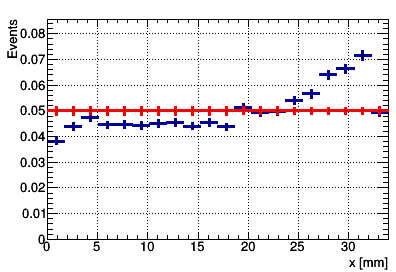

In [16]:
h = create_TH1D(sdata['x'], title='', binning=[N_bins[0], None, np.max(sdata['x'])*1.001], axis_title=['x [mm]', 'Events'])
h.SetStats(0)
h.Scale(1./h.GetEntries())
h.GetYaxis().SetRangeUser(0, 1.2*h.GetMaximum())

w = np.array(map(lambda x: 1./h.GetBinContent(h.FindBin(x)), sdata['x']))
w *= w.shape[0]/np.sum(w)
h_w = create_TH1D(sdata['x'], binning=h.binning, weights=w)
h_w.Scale(1./h_w.GetEntries())
h_w.SetLineColor(2)
h_w.SetStats(0)


c = rt.TCanvas('c', 'c', 400, 300)
h.Draw()
h_w.Draw('SAME')
c.Draw()

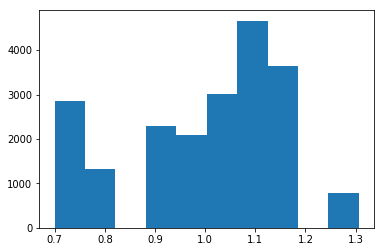

In [17]:
out = plt.hist(w, range=[np.min(w), np.max(w)])

### Raw

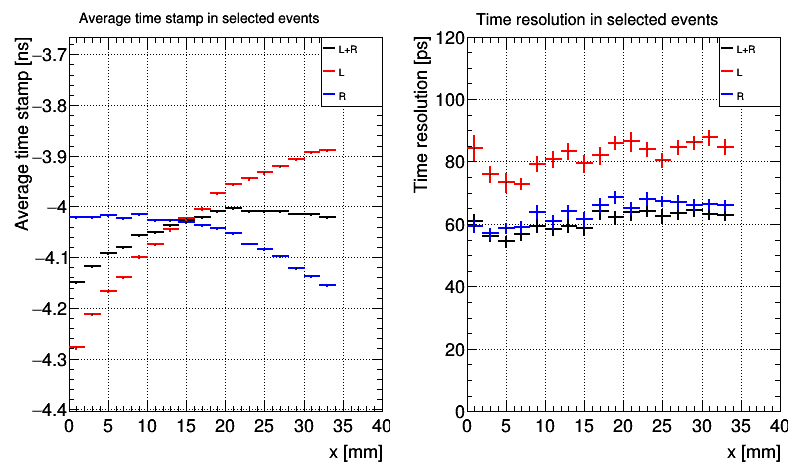

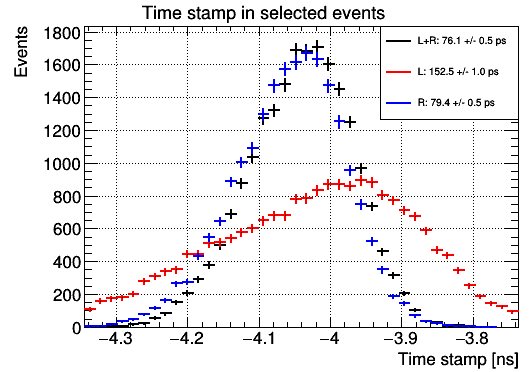

In [18]:
out = plot_it(sdata['dT'], sdata['dTL'], sdata['dTR'], weights=w)

### Global amp correction

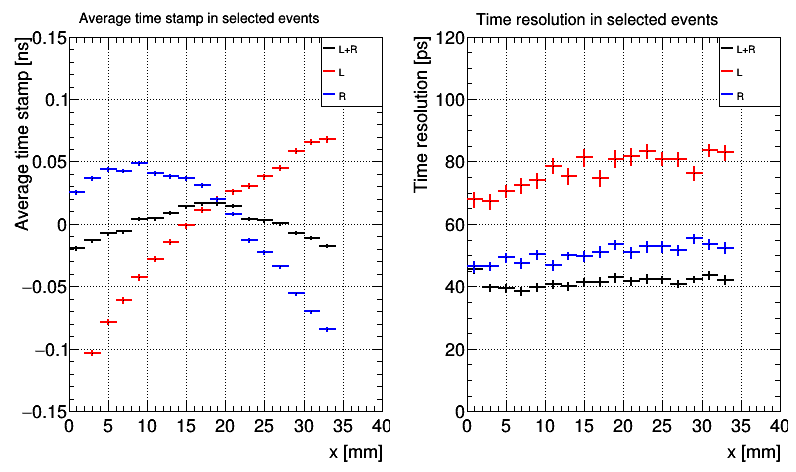

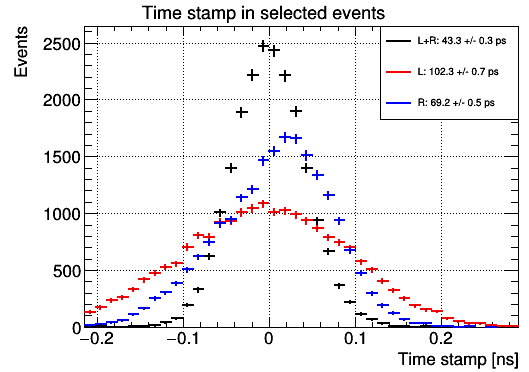

In [19]:
aux = [np.ones_like(sdata['dT']), sdata['ampL'], sdata['ampR'],
       np.square(sdata['ampL']), np.square(sdata['ampR']),
       sdata['ampL']*sdata['ampR'],
       sdata['xlike']
      ]
dtS = ApplyCorrections(sdata['dT'], aux)

aux = [np.ones_like(sdata['dTL']), sdata['ampL'],
       np.square(sdata['ampL'])
      ]
dtL = ApplyCorrections(sdata['dTL'], aux)

aux = [np.ones_like(sdata['dTR']), sdata['ampR'],
       np.square(sdata['ampR'])
      ]
dtR = ApplyCorrections(sdata['dTR'], aux)

out = plot_it(dtS, dtL, dtR, lims = [[-0.15,0.15], None, None], weights=w)

### Global space correction

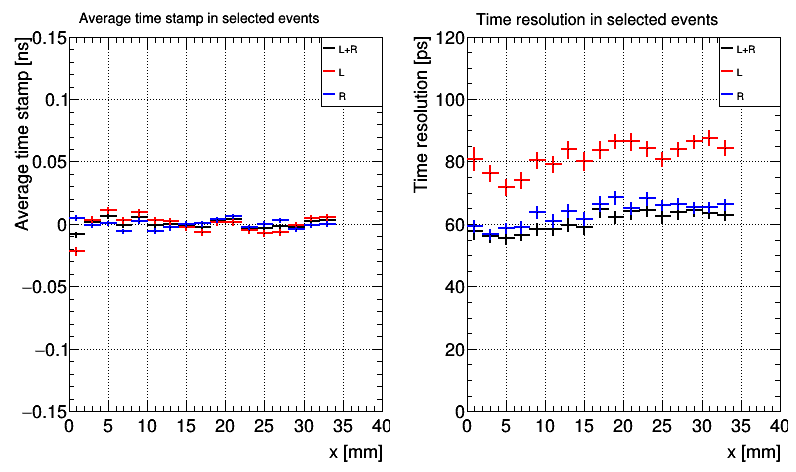

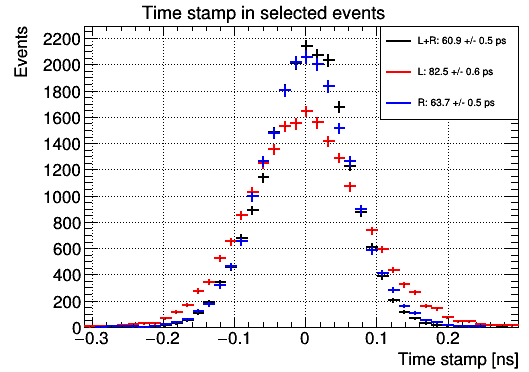

In [20]:
aux = [np.ones_like(sdata['dT']), sdata['x'], sdata['x'],
       np.square(sdata['x'])
      ]
dtS = ApplyCorrections(sdata['dT'], aux)

dtL = ApplyCorrections(sdata['dTL'], aux)

dtR = ApplyCorrections(sdata['dTR'], aux)

out = plot_it(dtS, dtL, dtR, lims = [[-0.15,0.15], None, None], weights=w)

### Global amp and space correction

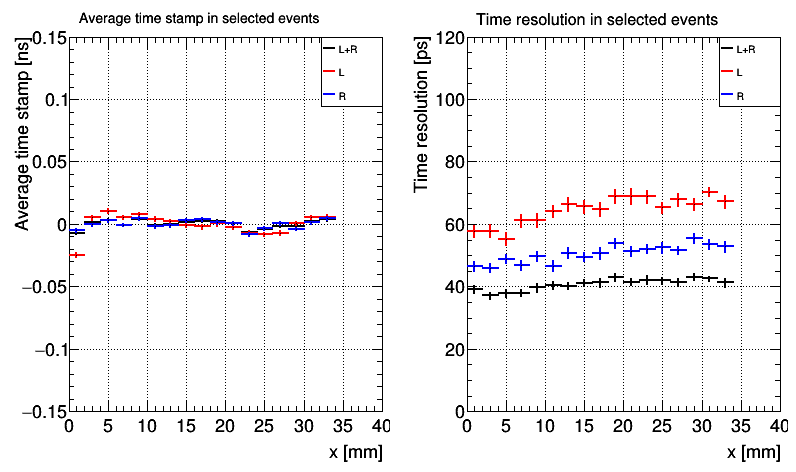

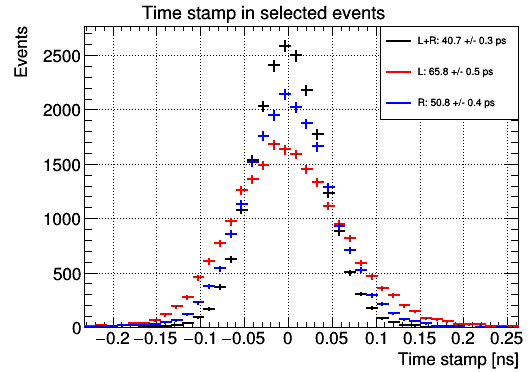

In [21]:
aux = [np.ones_like(sdata['dT']), sdata['ampL'], sdata['ampR'],
       np.square(sdata['ampL']), np.square(sdata['ampR']),
       sdata['ampL']*sdata['ampR'],
       sdata['xlike'],
       sdata['x'], np.square(sdata['x'])
      ]
dtS = ApplyCorrections(sdata['dT'], aux)

aux = [np.ones_like(sdata['dTL']), sdata['ampL'],
       np.square(sdata['ampL']),
       sdata['x'], np.square(sdata['x'])
      ]
dtL = ApplyCorrections(sdata['dTL'], aux)

aux = [np.ones_like(sdata['dTR']), sdata['ampR'],
       np.square(sdata['ampR']),
       sdata['x'], np.square(sdata['x'])
      ]
dtR = ApplyCorrections(sdata['dTR'], aux)

out = plot_it(dtS, dtL, dtR, lims = [[-0.15,0.15], None, None], weights=w)

### Local amp correction

In [22]:
x_sec, x_step = np.linspace(-width_x+dx, width_x+dx, N_bins[0], retstep=True)

In [23]:
dtS = np.zeros_like(sdata['dT'])
dtL = np.zeros_like(sdata['dTL'])
dtR = np.zeros_like(sdata['dTR'])

for ib, (xl, xu) in enumerate(zip(x_sec[:-1], x_sec[1:])):
    sel = np.logical_and(sdata['x']<xu, sdata['x']>xl)
    if np.sum(sel) == 0:
        continue
    idxs = np.argwhere(sel).T
    
    aux = [np.ones_like(sdata['dT'])[sel], sdata['ampL'][sel], sdata['ampR'][sel],
           np.square(sdata['ampL'])[sel], np.square(sdata['ampR'])[sel],
           sdata['ampL'][sel]*sdata['ampR'][sel],
           sdata['xlike'][sel]
          ]
    dtS[idxs] = ApplyCorrections(sdata['dT'][sel], aux)

    aux = [np.ones_like(sdata['dTL'])[sel], sdata['ampL'][sel],
           np.square(sdata['ampL'])[sel]]
    dtL[idxs] = ApplyCorrections(sdata['dTL'][sel], aux)

    aux = [np.ones_like(sdata['dTR'])[sel], sdata['ampR'][sel],
           np.square(sdata['ampR'])[sel]]
    dtR[idxs] = ApplyCorrections(sdata['dTR'][sel], aux)

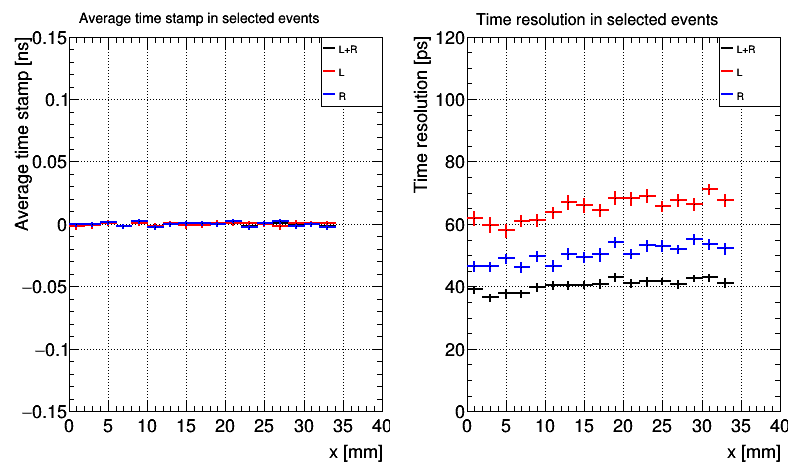

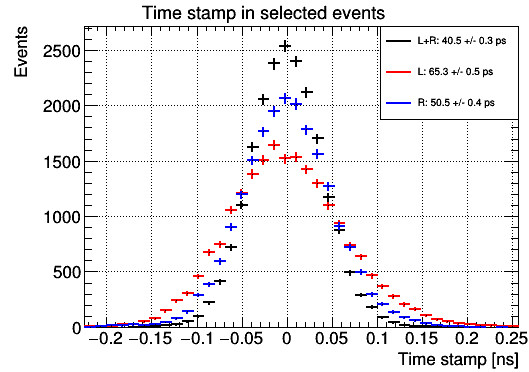

In [24]:
out = plot_it(dtS, dtL, dtR, lims = [[-0.15,0.15], None, None], weights=w)